# Influence of the max subgraph size parameter (Impact on the cost of the schedule)

For the explanation and results of this experiment please refer to [this context](https://github.com/mkroczek/SPWD-experiments/tree/master/experiments/mss_influence_results).

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../../"))

In [2]:
from QHyper.problems.workflow_scheduling import Workflow
from decomposition.qhyper.algorithm import WorkflowDecompositionQHyperAdapter
from decomposition.qhyper.solver import DecomposedWorkflowSchedulingSolver, WorkflowSchedulingSolverDecorator, WorkflowSchedule
from decomposition.qhyper.problem import WorkflowSchedulingOneHotEnhanced
from QHyper.solvers.classical.gurobi import Gurobi

import json
from abc import ABC, abstractmethod
from dataclasses import dataclass
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
class ExperimentResult(ABC):
    @abstractmethod
    def plot(self):
        pass


@dataclass
class AlgorithmRun:
    max_subgraph_size: int
    decomposition_schedule: WorkflowSchedule
    reference_schedule: WorkflowSchedule


class Experiment(ABC):
    def __init__(self, tasks_file, machines_file, deadline):
        self.tasks_file = tasks_file
        self.machines_file = machines_file
        self.deadline = deadline

    def _get_decomposed_solver(self, max_subgraph_size: int):
        workflow = Workflow(self.tasks_file, self.machines_file, self.deadline)
        division = WorkflowDecompositionQHyperAdapter(workflow).decompose(max_subgraph_size)
        problems = map(lambda w: WorkflowSchedulingOneHotEnhanced(w), division.workflows)
        solvers = map(lambda p: WorkflowSchedulingSolverDecorator(Gurobi(p)), problems)
        return DecomposedWorkflowSchedulingSolver(list(solvers), division)

    def _get_solver(self):
        workflow = Workflow(self.tasks_file, self.machines_file, self.deadline)
        return WorkflowSchedulingSolverDecorator(Gurobi(WorkflowSchedulingOneHotEnhanced(workflow)))

    def _schedule(self, max_subgraph_size: int) -> AlgorithmRun:
        return AlgorithmRun(
            max_subgraph_size,
            self._get_decomposed_solver(max_subgraph_size).solve(),
            self._get_solver().solve()
        )

    @abstractmethod
    def run(self) -> ExperimentResult:
        pass


def deadline_as_cpv(tasks_file, machines_file):
    workflow = Workflow(tasks_file, machines_file, 100000)
    mean_times = workflow.time_matrix.mean(axis=1).to_dict()

    def path_load(p):
        return sum([mean_times[t] for t in p])

    return int(max(path_load(p) for p in workflow.paths))

In [4]:
class MssInfluenceExperiment(Experiment):
    def __init__(self, tasks_file, machines_file, max_subgraph_sizes: list[int]):
        super().__init__(tasks_file, machines_file, deadline_as_cpv(tasks_file, machines_file))
        self.max_subgraph_sizes: list[int] = max_subgraph_sizes

    class MssInfluenceExperimentResult(ExperimentResult):
        def __init__(self, algorithm_runs: list[AlgorithmRun]):
            self.algorithm_runs = algorithm_runs
            self.cost_increase_per_mss = self._get_result_dict()

        def _get_result_dict(self) -> dict[int, float]:
            result = {}
            for algorithm_run in self.algorithm_runs:
                result[algorithm_run.max_subgraph_size] = self._calculate_cost_increase_ratio(algorithm_run)
            return result

        @staticmethod
        def _calculate_cost_increase_ratio(algorithm_run: AlgorithmRun) -> float:
            return algorithm_run.decomposition_schedule.cost / algorithm_run.reference_schedule.cost

        def plot(self, title: str = None):
            fig, ax = plt.subplots(1, 1, figsize=(15, 6))
            ax.plot(self.cost_increase_per_mss.keys(), self.cost_increase_per_mss.values(), 'o-', linewidth=2)
            ax.set_xlabel('Max subgraph size')
            ax.set_ylabel('Relative schedule cost increase')
            if title:
                ax.set_title(title)
            plt.show()
            
        def save_as_json(self, filename: str):
            with open(filename, 'w') as file:
                json.dump(obj=self.cost_increase_per_mss, fp=file, indent=4)

    def run(self) -> ExperimentResult:
        schedules = []
        for mss in self.max_subgraph_sizes:
            try:
                schedules.append(self._schedule(mss))
            except Exception as e:
                print(f"Unable to solve for max subgraph size = {mss}")
                raise e
        return self.MssInfluenceExperimentResult(schedules)

In [5]:
def measure_mss_influence_for_workflow_family(workflows: list[str], machines_file: str, divisions: list[float]):
    experiment_results: dict[int, MssInfluenceExperiment.MssInfluenceExperimentResult] = {}
    for tasks_file in workflows:
        workflow_size = len(Workflow(tasks_file, machines_file, 100000).tasks)
        max_subgraph_sizes = [int(multiplier * workflow_size) for multiplier in divisions]
        max_subgraph_sizes = [mss for mss in max_subgraph_sizes if mss >= 2]
        mss_influence_experiment = MssInfluenceExperiment(tasks_file, machines_file, max_subgraph_sizes)
        experiment_results[workflow_size] = mss_influence_experiment.run()
    return experiment_results

def plot_for_family(family, experiment_results, divisions, save: bool = True):
    fig, ax = plt.subplots(1, 1, figsize=(18,8))
    #fig, ax = plt.subplots(1, 1)
    
    for size, r in experiment_results.items():
        x = [int(mss * 100) for mss in divisions[:len(r.cost_increase_per_mss.values())]]
        y = [(cost_increase - 1) * 100.0 for cost_increase in r.cost_increase_per_mss.values()]
        ax.plot(x, y, 'o-', linewidth=2, label=f'{size} nodes')
    
    ax.set_xticks([int(division * 100) for division in divisions])
    ax.set_xticklabels(ax.get_xticks(), fontsize=18)
    ax.set_yticklabels(ax.get_yticks(), fontsize=18)
    # ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}'))
    ax.set_xlabel('Max subgraph size relative to workflow size [%]', fontsize=20)
    ax.set_ylabel('Schedule cost increase [%]', fontsize=20)
    # ax.set_title(f'Influence of the max subgraph size on the schedule cost for {family} workflows', fontsize=15)
    
    plt.legend(fontsize=20)
    plt.show()
    
    if save:
        fig.savefig(f"{family}/cost_increase_plot.png", bbox_inches='tight')

def save_family_as_json(family, experiment_results):
    for size, experiment_result in experiment_results.items():
        experiment_result.save_as_json(f"{family}/{size}.json")

# Epigenomics family

In [8]:
workflows = [
      # "/Users/marcinkroczek/code/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-6seq-100k-001.json",
      "/Users/marcinkroczek/code/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-1seq-100k-001.json", #41 nodes
      # "/Users/marcinkroczek/code/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-6seq-50k-001.json",
      # "/Users/marcinkroczek/code/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-3seq-100k-001.json"
]
machines_file = "../resources/machines/linear_smaller_diff.json"
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]

In [9]:
# %%capture
epigenomics_results = measure_mss_influence_for_workflow_family(workflows, machines_file, divisions)

/var/folders/8f/6k7c8wfn0f7dby3jlscldjv40000gn/T/ipykernel_14994/3163988594.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=18)


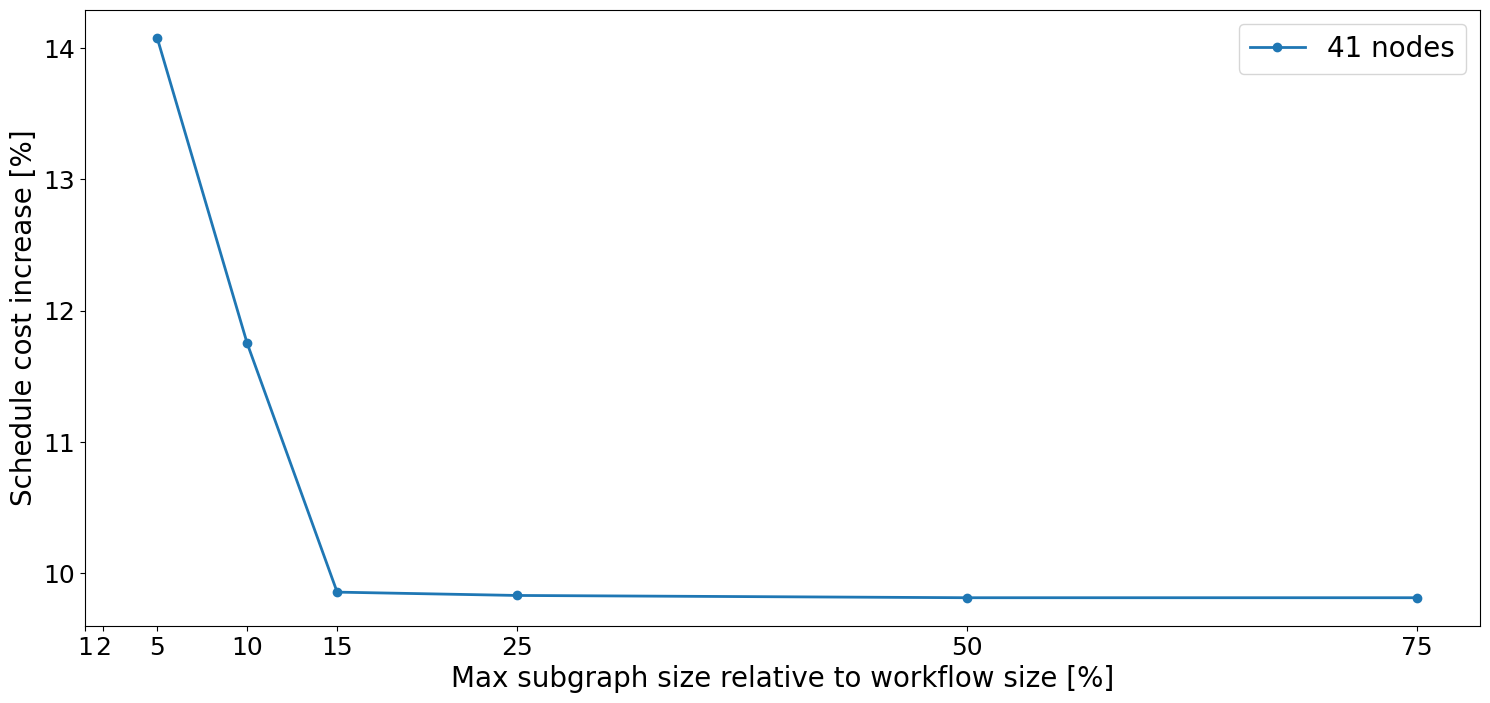

In [10]:
plot_for_family("Epigenomics", epigenomics_results, divisions)

In [9]:
save_family_as_json("Epigenomics", epigenomics_results)

# Montage family

In [ ]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-05d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-015d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-10d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-125d-001.json"
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]

In [ ]:
%%capture
montage_results = measure_mss_influence_for_workflow_family(workflows, machines_file, divisions)

In [ ]:
plot_for_family("Montage", montage_results, divisions)

# 1000genome family

In [ ]:
workflows = [
  "../workflows_data/workflows/1000genome-chameleon-22ch-100k-001.json",
  "../workflows_data/workflows/1000genome-chameleon-2ch-250k-001.json",
  "../workflows_data/workflows/1000genome-chameleon-6ch-250k-001.json",
  "../workflows_data/workflows/1000genome-chameleon-22ch-250k-001.json"
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]

In [ ]:
%%capture
family_results = measure_mss_influence_for_workflow_family(workflows, machines_file, divisions)

In [ ]:
plot_for_family("1000genome", sra_results, divisions)

In [ ]:
save_family_as_json("1000genome", family_results)

# SRA Search family

In [ ]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-30a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-20a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-40a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-10a-001.json"
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]

In [ ]:
%%capture
sra_results = measure_mss_influence_for_workflow_family(workflows, machines_file, divisions)

In [ ]:
plot_for_family("SRA_Search", sra_results, divisions)

In [ ]:
save_family_as_json("SRA_Search", sra_results)